In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time

# Update path
import sys
sys.path.append("../src/xArm6ManipulatorSourceFiles")
from models import DeepONetProjected, FNOProjected, FNOGRUNet, DeepONetGRUNet, ml_predictor_fno, ml_predictor_deeponet
from config import SimulationConfig, ModelConfig
from dataset import gen_dataset
from robot import Manipulator
from trainer import model_trainer, evaluate_train_performance, evaluate_model
from utils import plot_trajectory, count_parameters

%load_ext autoreload
%autoreload 2

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
#sim_config_path = "../config/manipulatorConfig/config.toml"
#sim_config = SimulationConfig(sim_config_path)

dynamics_config = {
    "dof": 6, # Controls number of manipulator links. Min=1, Max=5
    "T": 10, # Simulation final time
    "scaling": 0.1, # Controls the scale of the sin wave for trajectory following
    "period": 1, # Controls the period of the sin wave for trajectory following
    "dt": 0.1, # Simulation step size
    "D": 0.5 # Delay length
}

dataset_config = {
    "num_data": 250000, # Amount of data instances to generate
    "deviation": 0.5, # Controls how much Gaussian pertubation to add to predictor for generating dataset trajs
    "dataset_filename": "Manipulator", # Filename of dataset
    "test_size": 0.1, # Train test split size. Between 0 and 1
    "batch_size": 512, # Batch size used for loading dataset into torch dataloaders
    "random_state": 1, # Randomstate to start generating dataset from
    "device_name": "cuda" # CPU or GPU device for loading data on to 
}

# Uncomment to load file. 
#sim_config_path = "../config/manipulatorConfig/config.toml"
#sim_config = SimulationConfig(sim_config_path)

# Uncomment to load from above specifications
sim_config = SimulationConfig({"dynamics": dynamics_config, "dataset": dataset_config})

In [4]:
# Simulates the system
def simulate_system(robot, x0, qdes, qdesdot, qdesddot, dt, T, D, dof, predictor_func, model, verbose=True):
    t = np.arange(0, T, dt)
    q_vals = np.zeros((len(t), len(x0)))
    nD = int(round(D/dt))
    controls = np.zeros((len(t)+nD, dof))
    predictors = np.zeros((len(t), nD, len(x0)), dtype=np.float32)
    q_vals[0] = x0
    # Setup initial controllers. This matters - ALOT. 
    controllerStatic = robot.compute_control(q_vals[0], q_vals[0, :dof], np.zeros(dof), np.zeros(dof))
    controls[0:nD, :] = controllerStatic
    for i in range(1, len(t)):
        if verbose and i % 100 == 0:
            print(i, "/", len(t))
        if i > nD:
            prediction, predictions_arr = predictor_func(dt, q_vals[i-1], controls[i-1:i-1+nD], model) 
            controls[i-1+nD] = robot.compute_control(prediction, qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
            if predictions_arr is not None:
                predictors[i] = predictions_arr
        else:
            controls[i-1+nD] = robot.compute_control(q_vals[i-1], qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
            predictors[i] = np.tile(q_vals[i-1], nD).reshape(nD, len(q_vals[i-1]))
        q_vals[i] =  robot.saturate_joints(q_vals[i-1] + dt*robot.step_q(q_vals[i-1], controls[i-1]))
    return q_vals, controls, predictors

# Generate a trajecotry following a sinusoid
def generate_trajectory(joint_lim_min, joint_lim_max, scaling, period, dt, T, D, y_shift):
    t = np.arange(0, T+D, dt)
    q = np.zeros((len(t), len(joint_lim_min)))
    qd= np.zeros((len(t), len(joint_lim_min)))
    qdd = np.zeros((len(t), len(joint_lim_min)))
    for i in range(len(t)):
        # ensures positive q so we are in the joints
        q[i] = [math.sin(t[i]*period)*scaling ]*len(joint_lim_min) + y_shift
        qd[i] = [math.cos(t[i]*period)*scaling*period]*len(joint_lim_min)
        qdd[i] = [-math.sin(t[i]*period)*scaling*period**2] * len(joint_lim_min)
        if (np.maximum(np.minimum(q[i], joint_lim_max), joint_lim_min) != q[i]).any():
            raise Exception("Trajectory not feasible")
    return q, qd, qdd

def sim_trajectories(num_trajs, joint_lim_min, joint_lim_max, traj, randomization_variance, robot, model, predictor_func, sim_config, verbose=True):
    q_des, qd_des, qdd_des = traj[0], traj[1], traj[2]
    desired_states =  np.concatenate([q_des, qd_des], axis=1)
    best_tracking_error = np.inf
    worst_tracking_error = 0
    best_tracking_ic = None
    worst_tracking_ic = None
    tracking_error_arr = []
    prediction_error_arr = []
    np.random.seed(sim_config.random_state)
    for i in range(num_trajs):
        noise = np.random.uniform(-0.2, 0.2, sim_config.dof)
        init_cond = (joint_lim_max+joint_lim_min) / 2.0 + noise
        init_cond = np.array([init_cond, np.zeros(sim_config.dof)]).reshape(2*sim_config.dof)
        states, controls, predictors = simulate_system(robot, init_cond, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         predictor_func, model,verbose=True)
        cur_tracking_error = np.sum(np.linalg.norm(states-desired_states[:len(states)], axis=1))
        tracking_error_arr.append(cur_tracking_error)
        prediction_error_arr.append(np.mean(np.linalg.norm(predictors[sim_config.nD+1:-4, -1]-states[sim_config.nD+5:], axis=1)))
        if cur_tracking_error < best_tracking_error:
            best_tracking_ic = init_cond
            best_tracking_error = cur_tracking_error
        if cur_tracking_error > worst_tracking_error:
            worst_tracking_ic = init_cond
            worst_tracking_error = cur_tracking_error
    avg_tracking_error = np.mean(np.array(tracking_error_arr))
    avg_prediction_error = np.mean(np.array(prediction_error_arr))
    return best_tracking_ic, worst_tracking_ic, avg_tracking_error, avg_prediction_error

In [5]:
# Choose gain matrices for the feedback linearization in the sim
alpha_matrix = np.identity(sim_config.dof)
beta_matrix = np.identity(sim_config.dof)

# Set max and min joint limits
joint_lim_min = np.array([-6.2832, -2.0595, -3.92699, -6.2832, -1.69297, -6.2832])
joint_lim_max = np.array([6.2832, 2.0944, 0.19199, 6.2832, 3.1416, 6.2832])
joint_lim_min = joint_lim_min[0:sim_config.dof]
joint_lim_max = joint_lim_max[0:sim_config.dof]

# Build the simulation object and trajectory
robot = Manipulator(sim_config.dof, alpha_matrix, beta_matrix)
y_shift = (joint_lim_max+joint_lim_min) / 2.0
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, sim_config.scaling, sim_config.period, sim_config.dt, sim_config.T, sim_config.D, y_shift)

In [6]:
# Numerical
_, _, tracking_error_numerical, prediction_error_numerical = \
    sim_trajectories(25, joint_lim_min, joint_lim_max, (qdes, qd_des, qdd_des), \
                     0.2, robot, None, robot.compute_predictors, sim_config, True)

In [7]:
tracking_error_numerical, prediction_error_numerical

(np.float64(17.71310864034027), np.float64(3.772486335241903e-08))

In [8]:
noise = np.random.uniform(-0.2, 0.2, sim_config.dof)
init_cond = (joint_lim_max+joint_lim_min) / 2.0 + noise
init_cond = np.array([init_cond, np.zeros(sim_config.dof)]).reshape(2*sim_config.dof)
q_vals, controls, predictors = simulate_system(robot, init_cond, qdes, qd_des, qdd_des, sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors,None ,verbose=True)

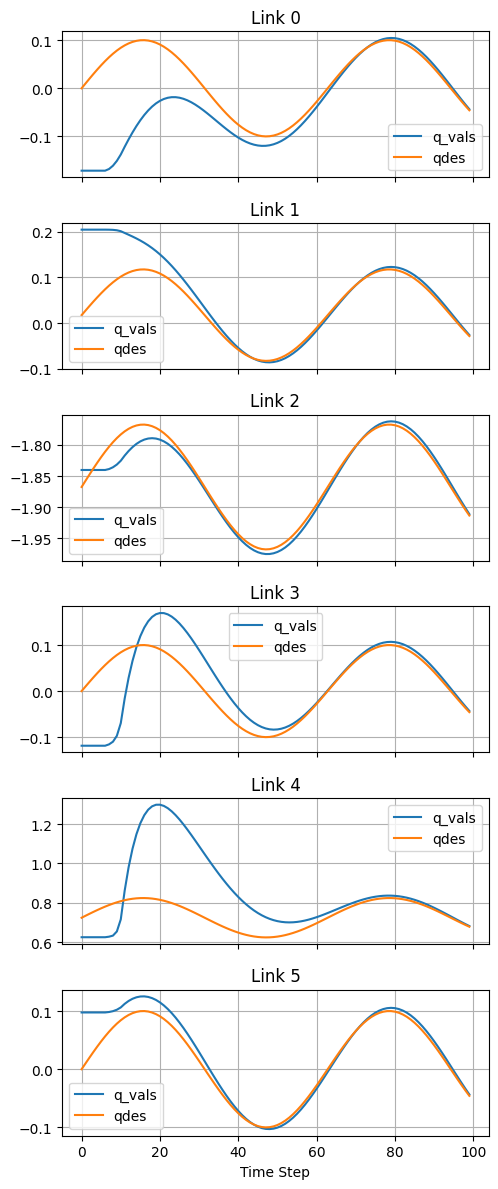

In [9]:
fig, axes = plt.subplots(sim_config.dof, 1, figsize=(5, 12), sharex=True)

for link in range(sim_config.dof):
    axes[link].plot(q_vals[:, link], label='q_vals')
    axes[link].plot(qdes[:-5, link], label='qdes')
    axes[link].set_title(f'Link {link}')
    axes[link].legend()
    axes[link].grid(True)

plt.xlabel('Time Step')
plt.tight_layout()
plt.show()

# Sanity checks

https://chatgpt.com/share/688eb716-2eb8-8009-889c-c2d0dae9f00c

In [40]:
q = np.zeros(robot.dof)
qdot = np.zeros(robot.dof)
torque = np.zeros(robot.dof)
X = np.concatenate([q, qdot])
next_state = robot.step_q(X, torque)
print("State derivative (should be zero):", next_state)


State derivative (should be zero): [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.24265607e-15 -9.01372216e-01
  2.89991734e+01  4.19832297e+01  1.99727952e+02  1.75350439e+00]


In [41]:
q = np.random.uniform(low=-1.0, high=1.0, size=robot.dof)
qdot = np.zeros(robot.dof)
X = np.concatenate([q, qdot])
torque = np.zeros(robot.dof)
state_dot = robot.step_q(X, torque)
print("Joint accelerations from gravity:", state_dot[robot.dof:])


Joint accelerations from gravity: [-1.94248095e-13  2.99669973e-01  3.78152131e+01 -5.75126951e+01
 -7.33150339e+00  9.09027444e-01]


/home/shigroup/gokul/NeuralOperatorPredictorFeedback-xArm6/examples/../src/manipulatorSourceFiles/robot.py:288: RuntimeWarning: overflow encountered in scalar multiply
  sum_m = sum_m + h3[i,k,m_idx] * qdot[k] * qdot[m_idx]
/home/shigroup/gokul/NeuralOperatorPredictorFeedback-xArm6/examples/../src/manipulatorSourceFiles/robot.py:288: RuntimeWarning: invalid value encountered in scalar add
  sum_m = sum_m + h3[i,k,m_idx] * qdot[k] * qdot[m_idx]


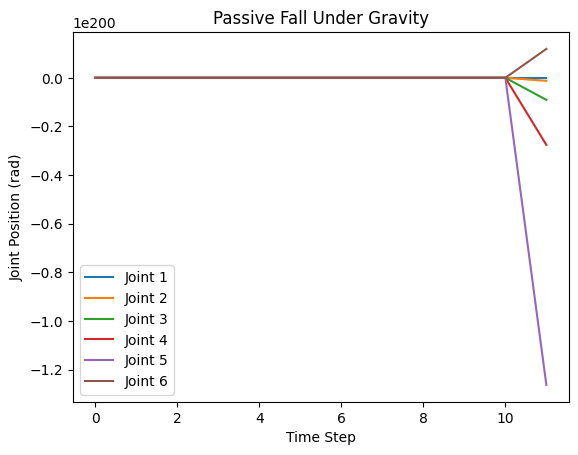

In [42]:
def simulate_fall(robot, X0, dt=0.01, steps=500):
    traj = np.zeros((steps+1, 2*robot.dof))
    traj[0] = X0
    for i in range(steps):
        traj[i+1] = traj[i] + dt * robot.step_q(traj[i], np.zeros(robot.dof))
    return traj

import matplotlib.pyplot as plt
X0 = np.concatenate([np.random.uniform(-1, 1, robot.dof), np.zeros(robot.dof)])
traj = simulate_fall(robot, X0)

for i in range(robot.dof):
    plt.plot(traj[:, i], label=f'Joint {i+1}')
plt.title("Passive Fall Under Gravity")
plt.xlabel("Time Step")
plt.ylabel("Joint Position (rad)")
plt.legend()
plt.show()
